In [5]:
import HHBlits
import get_cullin_e3_ppi_from_pdb70
import cullin_benchmark_test
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import Path
import scipy as sp
from Bio import SeqIO
import sys
import numpyro
import lpmf
import lpdf
from _search_producers import metropolis_hastings
import jax
import jax.numpy as jnp

In [11]:
cullin_benchmark = cullin_benchmark_test.CullinBenchMark(
    dirpath=Path("../../data/raw/cullin_e3_ligase/"))
cullin_benchmark.parse_spec_counts(drop_spec_columns=True)
# select only one bait

selector = cullin_benchmark.data["Bait"] == "CBFBwt_MG132"
cbfb = cullin_benchmark.data.loc[selector, :]
selector = cullin_benchmark.data["Bait"] == "ELOBwt_MG132"
elob = cullin_benchmark.data.loc[selector, :]
selector = cullin_benchmark.data["Bait"] == "CUL5wt_MG132"
cul5 = cullin_benchmark.data.loc[selector, :]

{'CBFBwt_MG132', 'CUL5wt_MG132', 'ELOBwt_MG132'}

In [3]:
t_min = 0.5
sel = cbfb.data['SaintScore'] >= 0.5
prey = cbfb.data.loc[sel, :]
saint_score = prey['SaintScore'].values


def random_composite(key):
    t = jax.random.uniform(k1)
    locs = saint_score >= t
    return jnp.where(locs)
    

In [ ]:
jnp.where(saint_score > 0.3)

In [3]:
col = cbfb.data["Prey"]
assert len(set(col)) == len(col)

/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Bait: CBFβ\nHIV infected JURKAT T-Cells')

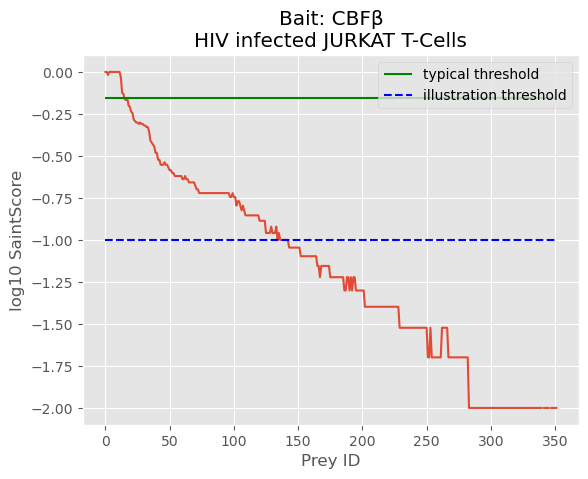

In [4]:
plt.style.use('ggplot')
plt.plot(np.log10(cbfb.data["SaintScore"]))
plt.xlabel('Prey ID')
plt.ylabel('log10 SaintScore')
plt.hlines(np.log10(0.7), 0, 350, 'g', label='typical threshold')
plt.hlines(np.log10(0.1), 0, 350, 'b',
           linestyles='dashed',
           label='illustration threshold')
plt.legend()
title = u'Bait: CBF\u03B2\nHIV infected JURKAT T-Cells'
plt.title(title)

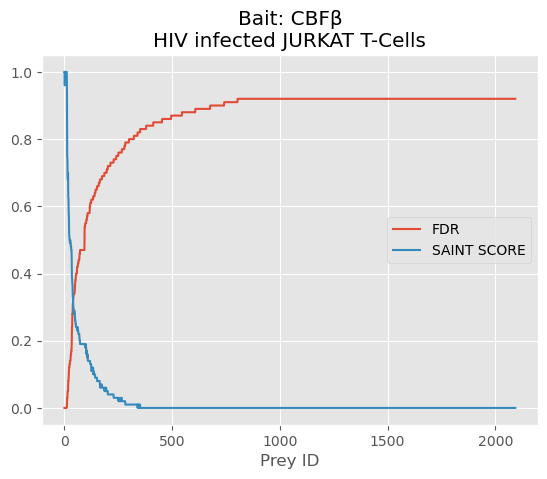

In [5]:
def fdr_sscore_plot(df, title=title):
    plt.plot(df['BFDR'], label='FDR')
    plt.plot(df['SaintScore'], label='SAINT SCORE')
    plt.legend()
    plt.xlabel('Prey ID')
    plt.title(title)
    
fdr_sscore_plot(cbfb.data)

Text(0.5, 1.0, 'Bait: CBFβ\nHIV infected JURKAT T-Cells')

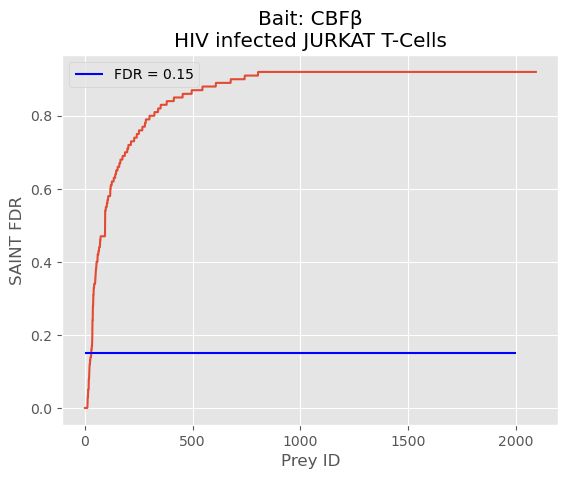

In [6]:
plt.plot(cbfb.data['BFDR'])
plt.xlabel('Prey ID')
plt.ylabel('SAINT FDR')
plt.hlines(0.15, 0, 2000, 'b', label='FDR = 0.15')
plt.legend()
plt.title(title)

Text(0.5, 1.0, 'Bait: CBFβ\nHIV infected JURKAT T-Cells')

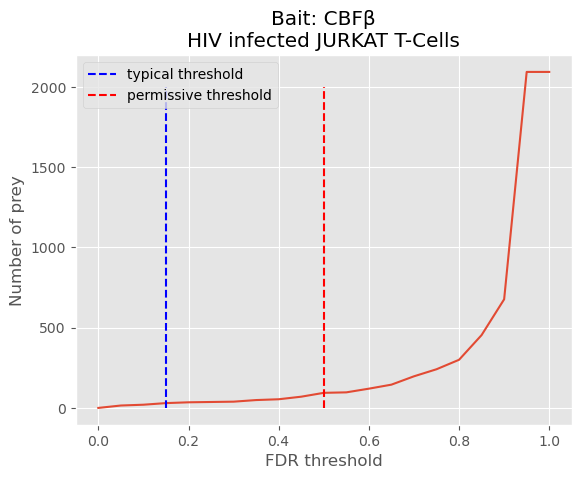

In [7]:
fdr_thresholds = np.arange(0, 1.05, 0.05)
n_prey = [len(cbfb.data.loc[cbfb.data["BFDR"] < t, :]) for t in fdr_thresholds]
plt.plot(fdr_thresholds, n_prey)
plt.ylabel("Number of prey")
plt.xlabel("FDR threshold")
plt.vlines(0.15, 0, 2000, 'b', label='typical threshold', linestyles='dashed')
plt.vlines(0.5, 0, 2000, 'r', label='permissive threshold', linestyles='dashed')
plt.legend()
plt.title(title)

In [8]:
n_prey_fdr_lt_015 = len(cbfb.data.loc[cbfb.data["BFDR"] < 0.15, :])
n_prey_fdr_lt_030 = len(cbfb.data.loc[cbfb.data["BFDR"] < 0.30, :])
n_prey_prob_07 = len(cbfb.data.loc[cbfb.data["SaintScore"]>=0.7, :])

print((f"number of prey with  FDR <  0.15  {n_prey_fdr_lt_015}"
       f"\nnumber of prey with prob >= 0.5   {n_prey_prob_07}"
       f"\nnumber of prey with  FDR <  0.30  {n_prey_fdr_lt_030}"))

number of prey with  FDR <  0.15  29
number of prey with prob >= 0.5   16
number of prey with  FDR <  0.30  39


In [9]:
selector = cbfb.data["BFDR"] <= 0.5
cbfb.data = cbfb.data.loc[selector, :]

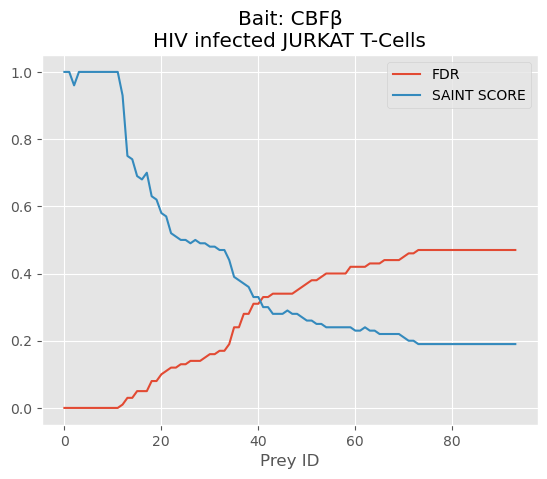

In [13]:
fdr_sscore_plot(cbfb.data)

In [19]:
def xy_plot(df, xcol, ycol, plotargs):
    plt.plot(df[xcol], df[ycol], *plotargs)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    


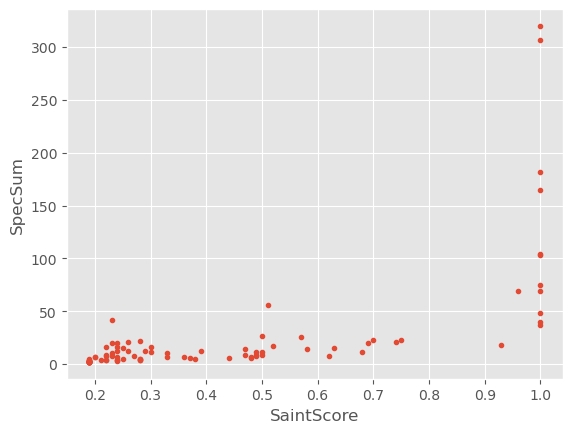

In [21]:
xy_plot(cbfb.data, 'SaintScore', 'SpecSum', '.')

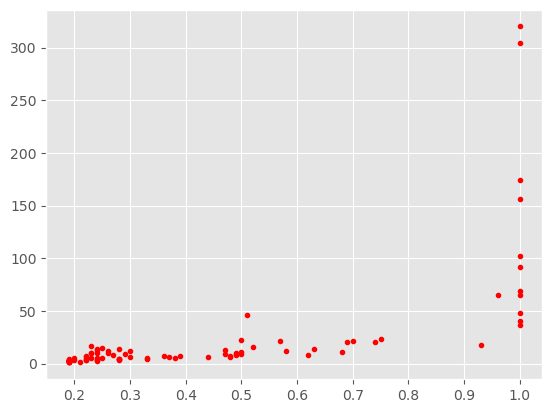

In [28]:

control_sum = cbfb.data.loc[:, [f"c{i}" for i in range(1, 5)]].sum(axis=1)
plt.plot(cbfb.data['SaintScore'], cbfb.data['SpecSum'] - control_sum, 'r.')

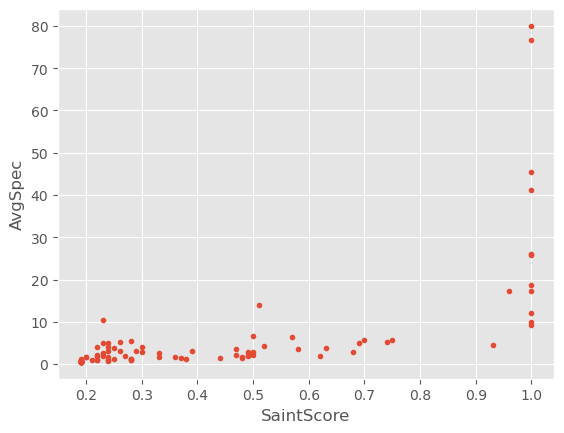

In [31]:
xy_plot(cbfb.data, 'SaintScore', 'AvgSpec', '.')

In [43]:
cbfb.data.sort_values('AvgSpec', ascending=False).iloc[0:20, :]

,Bait,Prey,PreyGene,SpecSum,AvgSpec,NumReplicates,AvgP,MaxP,TopoAvgP,TopoMaxP,...,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12
3,CBFBwt_MG132,Q93034,CUL5_HUMAN,320,80.00,4,1.00,1.00,1.00,1.00,...,0,0,0,0,0,1,0,0,1,0
10,CBFBwt_MG132,Q13617,CUL2_HUMAN,307,76.75,4,1.00,1.00,1.00,1.00,...,0,1,4,0,2,3,1,0,1,0
11,CBFBwt_MG132,Q01196,RUNX1_HUMAN,182,45.50,4,1.00,1.00,1.00,1.00,...,3,2,0,2,4,1,2,2,0,0
7,CBFBwt_MG132,Q13951,PEBB_HUMAN,165,41.25,4,1.00,1.00,1.00,1.00,...,3,3,0,0,5,3,0,0,0,0
0,CBFBwt_MG132,vifprotein,vifprotein,104,26.00,4,1.00,1.00,1.00,1.00,...,1,1,0,1,3,2,1,0,0,0
5,CBFBwt_MG132,Q15370,ELOB_HUMAN,103,25.75,4,1.00,1.00,1.00,1.00,...,2,3,5,4,6,3,5,4,3,4
6,CBFBwt_MG132,Q15369,ELOC_HUMAN,75,18.75,4,1.00,1.00,1.00,1.00,...,2,2,2,2,7,4,4,4,5,4
2,CBFBwt_MG132,Q9C0K0,BC11B_HUMAN,69,17.25,4,0.96,1.00,0.96,1.00,...,2,0,3,1,1,0,4,3,1,1
4,CBFBwt_MG132,Q8TEB1,DCA11_HUMAN,69,17.25,4,1.00,1.00,1.00,1.00,...,0,0,0,1,3,0,1,0,1,0
23,CBFBwt_MG132,P52272,HNRPM_HUMAN,56,14.00,4,0.51,0.97,0.51,0.97,...,5,2,8,4,8,7,3,1,0,2


In [41]:
cbfb.data

,Bait,Prey,PreyGene,SpecSum,AvgSpec,NumReplicates,AvgP,MaxP,TopoAvgP,TopoMaxP,...,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12
0,CBFBwt_MG132,vifprotein,vifprotein,104,26.00,4,1.00,1.00,1.00,1.00,...,1,1,0,1,3,2,1,0,0,0
1,CBFBwt_MG132,Q9UBF6,RBX2_HUMAN,48,12.00,4,1.00,1.00,1.00,1.00,...,0,0,0,0,0,0,1,0,0,0
2,CBFBwt_MG132,Q9C0K0,BC11B_HUMAN,69,17.25,4,0.96,1.00,0.96,1.00,...,2,0,3,1,1,0,4,3,1,1
3,CBFBwt_MG132,Q93034,CUL5_HUMAN,320,80.00,4,1.00,1.00,1.00,1.00,...,0,0,0,0,0,1,0,0,1,0
4,CBFBwt_MG132,Q8TEB1,DCA11_HUMAN,69,17.25,4,1.00,1.00,1.00,1.00,...,0,0,0,1,3,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,CBFBwt_MG132,P15927,RFA2_HUMAN,3,0.75,4,0.19,0.77,0.19,0.77,...,0,0,0,0,0,0,0,0,0,0
90,CBFBwt_MG132,O95239,KIF4A_HUMAN,2,0.50,4,0.19,0.77,0.19,0.77,...,0,0,0,1,0,0,0,0,0,0
91,CBFBwt_MG132,O75419,CDC45_HUMAN,4,1.00,4,0.19,0.77,0.19,0.77,...,0,0,0,0,0,0,0,0,0,0
92,CBFBwt_MG132,O14776,TCRG1_HUMAN,3,0.75,4,0.19,0.77,0.19,0.77,...,0,0,0,0,0,0,0,0,0,0
